# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1YvNkQE_gRD-02d4WIk_NjxEGEwsuZYwH?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [2]:
# import the needed libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data Loading from Google Drive
filePath = '/content/gdrive/My Drive/Colab Notebooks/aps360/Lab3/Lab3_Dataset/Lab3_Gestures'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# resize images and transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
# import data
data = torchvision.datasets.ImageFolder(filePath, transform=transform)  

In [ ]:
# Split into train, test, and validation
# 60% training  20% validation  20% testing samples
trainLength = int(round(0.6 * len(data)))
testLength = int(round(0.2 * len(data)))
valLength = int(round(0.2 * len(data)))
trainset, testset, validset = torch.utils.data.random_split(data,[trainLength,testLength,valLength])
    
# load data
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(validset, batch_size=32,num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32,num_workers=1, shuffle=True)


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
# 2 convolutional layers with kernel size 5
# There are 3 input channels and 5 output channels in the 1st convolutional layer
# There are 5 input channels and 10 output channels in the 2nd convolutional layer
# 2 maxpooling layers with kernel size 2 and stride 2
# activation function: ReLu 
# 2 fully-connected layers after the pooling layer
# Totally 7 layers: 2 convolutional layers,2 pooling layers, 2 fully-connected layers, and 1 output layer
torch.manual_seed(69) # set the random seed
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)
        self.fc1 = nn.Linear(10*53*53, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*53*53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
class CNN(nn.Module):
  # The CNN contains 3 convolution layers, 1 fully connected layer, 1 global average pooling
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 8, kernel_size = 3, stride = 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 2) 
        self.conv3  = nn.Conv2d(16, 32, kernel_size = 3, stride = 2) 
        self.avgpool = nn.GovalAvgPooling(kernel_size = 3, stride = 2,padding = 1)
        self.fc1 = nn.Linear(32, 100)
    
    #relu activation function are used
    def forward(self, x):
        x = self.avgpool(F.relu(self.conv1(x))) 
        x = self.avgpool(F.relu(self.conv2(x)))
        x = self.avgpool(F.relu(self.conv3(x)))
        x = x.view(-1, 32)
        x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

I use the cross entropy loss function because cross entropy is mostly used for classification problems.

I use SGD optimizer because SGD is much faster and requires less tuning.

In [ ]:
# code from tutorial 
use_cuda = True
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data:   
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
        #############################################
        
        
      output = model(imgs)
        
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
    return correct / total

In [ ]:
def train(net,train_loader, val_loader, batch_size,learning_rate, num_epochs):
    # fixed PyTorch random seed
    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    iters = np.zeros(num_epochs)
    losses = np.zeros(num_epochs)
    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            
            optimizer.zero_grad()         # a clean up step for PyTorch  
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

        # save the current training information
        iters[epoch] = n
        losses[epoch] = (float(loss)/batch_size) # compute *average* loss
        n += 1
        train_acc[epoch] = get_accuracy(net, train_loader)# compute training accuracy 
        val_acc[epoch] = get_accuracy(net, val_loader)# compute validation accuracy
        print("Epoch: {}, Train Accuracy: {}".format(epoch, train_acc[epoch]))
        print("Epoch: {}, Val Accuracy: {}".format(epoch, val_acc[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# small data load
filePath = '/content/gdrive/My Drive/Colab Notebooks/aps360/Lab3/Lab3_Dataset/Lab3_small_Gestures'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# resize images and transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
# import data(3*9=27 images totally)
smalldata = torchvision.datasets.ImageFolder(filePath, transform=transform)  

In [ ]:
# Split into small train, test, and validation
# 21 training  3 validation  3 testing samples
small_trainset, small_testset, small_validset = torch.utils.data.random_split(smalldata,[21,3,3])
    
# load data
small_train_loader = torch.utils.data.DataLoader(small_trainset, batch_size=32, num_workers=1, shuffle=True)
small_val_loader = torch.utils.data.DataLoader(small_validset, batch_size=32,num_workers=1, shuffle=True)
small_test_loader = torch.utils.data.DataLoader(small_testset, batch_size=32,num_workers=1, shuffle=True)


In [ ]:
def train_small(net,train_loader, val_loader, batch_size,learning_rate, num_epochs):
    # fixed PyTorch random seed
    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    iters = np.zeros(num_epochs)
    losses = np.zeros(num_epochs)
    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            
            optimizer.zero_grad()         # a clean up step for PyTorch  
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

        # save the current training information
        iters[epoch] = n
        losses[epoch] = (float(loss)/batch_size) # compute *average* loss
        n += 1
        train_acc[epoch] = get_accuracy(net, train_loader)# compute training accuracy 
        val_acc[epoch] = get_accuracy(net, val_loader)# compute validation accuracy
        print("Epoch: {}, Train Accuracy: {}".format(epoch, train_acc[epoch]))
        print("Epoch: {}, Val Accuracy: {}".format(epoch, val_acc[epoch]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch: 0, Train Accuracy: 0.09523809523809523
Epoch: 0, Val Accuracy: 0.0
Epoch: 1, Train Accuracy: 0.09523809523809523
Epoch: 1, Val Accuracy: 0.3333333333333333
Epoch: 2, Train Accuracy: 0.14285714285714285
Epoch: 2, Val Accuracy: 0.0
Epoch: 3, Train Accuracy: 0.19047619047619047
Epoch: 3, Val Accuracy: 0.0
Epoch: 4, Train Accuracy: 0.19047619047619047
Epoch: 4, Val Accuracy: 0.0
Epoch: 5, Train Accuracy: 0.19047619047619047
Epoch: 5, Val Accuracy: 0.0
Epoch: 6, Train Accuracy: 0.19047619047619047
Epoch: 6, Val Accuracy: 0.0
Epoch: 7, Train Accuracy: 0.19047619047619047
Epoch: 7, Val Accuracy: 0.0
Epoch: 8, Train Accuracy: 0.19047619047619047
Epoch: 8, Val Accuracy: 0.0
Epoch: 9, Train Accuracy: 0.19047619047619047
Epoch: 9, Val Accuracy: 0.0
Epoch: 10, Train Accuracy: 0.19047619047619047
Epoch: 10, Val Accuracy: 0.0
Epoch: 11, Train Accuracy: 0.19047619047619047
Epoch: 11, Val Accuracy: 0.0
Epoch: 12, Train Accuracy: 0.19047619047619047
Epoch:

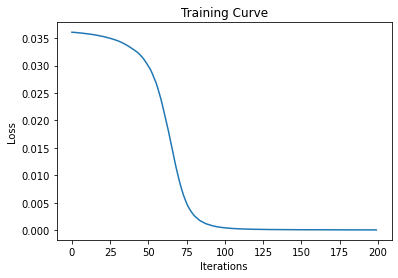

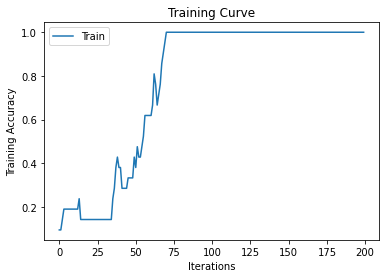

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [ ]:
cnn = CNN()

if use_cuda and torch.cuda.is_available():
  cnn.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_small(cnn,small_train_loader,small_val_loader,batch_size=64,learning_rate=0.001,num_epochs=200)

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
# Batch size
# Learning rate
# Number of epoches

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

CUDA is available!  Training on GPU ...
Epoch: 0, Train Accuracy: 0.10743801652892562
Epoch: 0, Val Accuracy: 0.10585585585585586
Epoch: 1, Train Accuracy: 0.11720510894064613
Epoch: 1, Val Accuracy: 0.10810810810810811
Epoch: 2, Train Accuracy: 0.12021036814425244
Epoch: 2, Val Accuracy: 0.11936936936936937
Epoch: 3, Train Accuracy: 0.22915101427498122
Epoch: 3, Val Accuracy: 0.25
Epoch: 4, Train Accuracy: 0.25920360631104433
Epoch: 4, Val Accuracy: 0.2545045045045045
Epoch: 5, Train Accuracy: 0.3959429000751315
Epoch: 5, Val Accuracy: 0.36261261261261263
Epoch: 6, Train Accuracy: 0.526671675432006
Epoch: 6, Val Accuracy: 0.46846846846846846
Epoch: 7, Train Accuracy: 0.4718256949661908
Epoch: 7, Val Accuracy: 0.4009009009009009
Epoch: 8, Train Accuracy: 0.5867768595041323
Epoch: 8, Val Accuracy: 0.5247747747747747
Epoch: 9, Train Accuracy: 0.6513899323816679
Epoch: 9, Val Accuracy: 0.5923423423423423


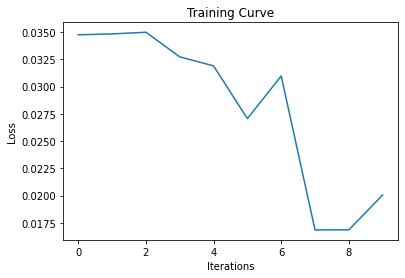

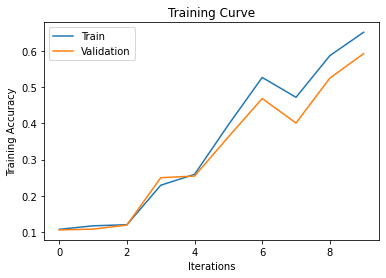

Final Training Accuracy: 0.6513899323816679
Final Validation Accuracy: 0.5923423423423423


In [ ]:
use_cuda = True
cnn_1 = CNN()
if use_cuda and torch.cuda.is_available(): 
  cnn_1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# batch_size = 64, learning_rate = 0.001, num_epochs=10
train(cnn_1,train_loader,val_loader,batch_size=64,learning_rate=0.001,num_epochs=10)

CUDA is available!  Training on GPU ...
Epoch: 0, Train Accuracy: 0.16453794139744554
Epoch: 0, Val Accuracy: 0.19369369369369369
Epoch: 1, Train Accuracy: 0.11419984973703982
Epoch: 1, Val Accuracy: 0.11711711711711711
Epoch: 2, Train Accuracy: 0.11344853493613824
Epoch: 2, Val Accuracy: 0.10135135135135136
Epoch: 3, Train Accuracy: 0.14199849737039819
Epoch: 3, Val Accuracy: 0.11936936936936937
Epoch: 4, Train Accuracy: 0.20586025544703232
Epoch: 4, Val Accuracy: 0.18468468468468469
Epoch: 5, Train Accuracy: 0.23741547708489857
Epoch: 5, Val Accuracy: 0.21396396396396397
Epoch: 6, Train Accuracy: 0.35311795642374155
Epoch: 6, Val Accuracy: 0.35135135135135137
Epoch: 7, Train Accuracy: 0.38467317806160783
Epoch: 7, Val Accuracy: 0.3333333333333333
Epoch: 8, Train Accuracy: 0.38016528925619836
Epoch: 8, Val Accuracy: 0.3536036036036036
Epoch: 9, Train Accuracy: 0.507137490608565
Epoch: 9, Val Accuracy: 0.4797297297297297
Epoch: 10, Train Accuracy: 0.4898572501878287
Epoch: 10, Val Accu

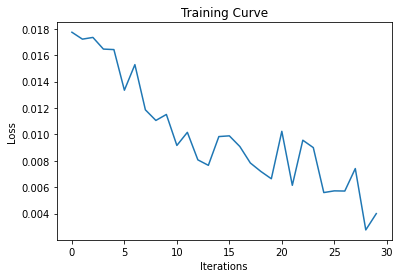

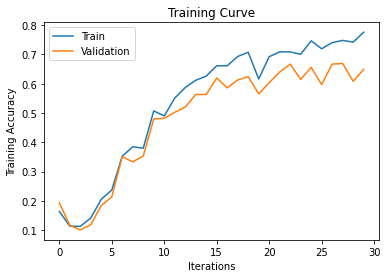

Final Training Accuracy: 0.7753568745304282
Final Validation Accuracy: 0.6486486486486487


In [ ]:
use_cuda = True
cnn_2 = CNN()
if use_cuda and torch.cuda.is_available():
  cnn_2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# Increase batch_size to 128, num_epochs to 30
train(cnn_2,train_loader,val_loader,batch_size=128,learning_rate=0.001,num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch: 0, Train Accuracy: 0.11570247933884298
Epoch: 0, Val Accuracy: 0.10585585585585586
Epoch: 1, Train Accuracy: 0.2659654395191585
Epoch: 1, Val Accuracy: 0.26126126126126126
Epoch: 2, Train Accuracy: 0.4357625845229151
Epoch: 2, Val Accuracy: 0.4391891891891892
Epoch: 3, Train Accuracy: 0.5522163786626596
Epoch: 3, Val Accuracy: 0.5135135135135135
Epoch: 4, Train Accuracy: 0.6318557475582269
Epoch: 4, Val Accuracy: 0.5630630630630631
Epoch: 5, Train Accuracy: 0.6311044327573253
Epoch: 5, Val Accuracy: 0.5563063063063063
Epoch: 6, Train Accuracy: 0.5980465815176559
Epoch: 6, Val Accuracy: 0.536036036036036
Epoch: 7, Train Accuracy: 0.6844477836213373
Epoch: 7, Val Accuracy: 0.6193693693693694
Epoch: 8, Train Accuracy: 0.7340345604808415
Epoch: 8, Val Accuracy: 0.668918918918919
Epoch: 9, Train Accuracy: 0.7340345604808415
Epoch: 9, Val Accuracy: 0.6531531531531531
Epoch: 10, Train Accuracy: 0.6393688955672426
Epoch: 10, Val Accuracy: 0.551801

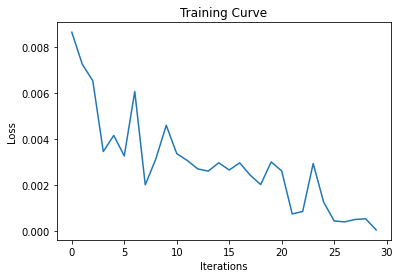

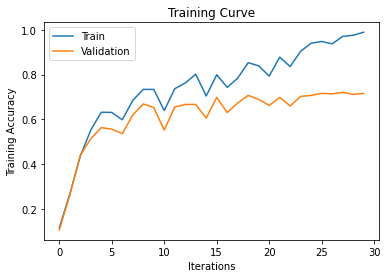

Final Training Accuracy: 0.9894815927873779
Final Validation Accuracy: 0.7162162162162162


In [ ]:
use_cuda = True
cnn_3 = CNN()
if use_cuda and torch.cuda.is_available():
  cnn_3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# Increase batch_size to 256, learning rate to 0.005
train(cnn_3,train_loader,val_loader,batch_size=256,learning_rate=0.005,num_epochs=30)

CUDA is available!  Training on GPU ...
Epoch: 0, Train Accuracy: 0.14124718256949662
Epoch: 0, Val Accuracy: 0.12837837837837837
Epoch: 1, Train Accuracy: 0.22689706987227648
Epoch: 1, Val Accuracy: 0.1981981981981982
Epoch: 2, Train Accuracy: 0.47858752817430505
Epoch: 2, Val Accuracy: 0.43018018018018017
Epoch: 3, Train Accuracy: 0.5559729526671675
Epoch: 3, Val Accuracy: 0.4797297297297297
Epoch: 4, Train Accuracy: 0.5897821187077386
Epoch: 4, Val Accuracy: 0.5495495495495496
Epoch: 5, Train Accuracy: 0.6438767843726522
Epoch: 5, Val Accuracy: 0.5833333333333334
Epoch: 6, Train Accuracy: 0.6543951915852743
Epoch: 6, Val Accuracy: 0.5743243243243243
Epoch: 7, Train Accuracy: 0.7054845980465815
Epoch: 7, Val Accuracy: 0.6103603603603603
Epoch: 8, Train Accuracy: 0.7265214124718257
Epoch: 8, Val Accuracy: 0.6261261261261262
Epoch: 9, Train Accuracy: 0.7332832456799399
Epoch: 9, Val Accuracy: 0.6554054054054054
Epoch: 10, Train Accuracy: 0.740045078888054
Epoch: 10, Val Accuracy: 0.641

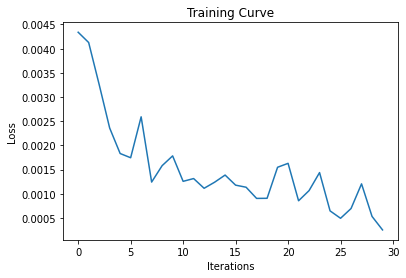

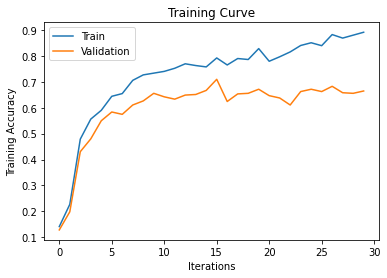

Final Training Accuracy: 0.8910593538692713
Final Validation Accuracy: 0.6644144144144144


In [ ]:
use_cuda = True
cnn_4 = CNN()
if use_cuda and torch.cuda.is_available():
  cnn_4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# Increase batch_size to 512,learning_rate to 0.003
train(cnn_4,train_loader,val_loader,batch_size=512,learning_rate=0.003,num_epochs=30)

In [ ]:
# new cnn
# add a fully connected layer --> total layer: 8
class new_CNN(nn.Module):
    def __init__(self):
        super(new_CNN, self).__init__()
        self.name = "new_CNN"
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        # change 2nd layer's kernel size to 7
        self.conv2 = nn.Conv2d(5, 10, kernel_size=7)
        self.fc1 = nn.Linear(10*53*53, 32)
        self.fc2 = nn.Linear(32, 20)
        # add new layer
        self.fc3 = nn.Linear(20,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10*53*53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


CUDA is available!  Training on GPU ...
Epoch: 0, Train Accuracy: 0.11570247933884298
Epoch: 0, Val Accuracy: 0.10585585585585586
Epoch: 1, Train Accuracy: 0.2659654395191585
Epoch: 1, Val Accuracy: 0.26126126126126126
Epoch: 2, Train Accuracy: 0.4417731029301277
Epoch: 2, Val Accuracy: 0.4527027027027027
Epoch: 3, Train Accuracy: 0.5492111194590533
Epoch: 3, Val Accuracy: 0.5067567567567568
Epoch: 4, Train Accuracy: 0.6258452291510143
Epoch: 4, Val Accuracy: 0.5698198198198198
Epoch: 5, Train Accuracy: 0.6258452291510143
Epoch: 5, Val Accuracy: 0.5630630630630631
Epoch: 6, Train Accuracy: 0.6716754320060105
Epoch: 6, Val Accuracy: 0.5833333333333334
Epoch: 7, Train Accuracy: 0.7032306536438768
Epoch: 7, Val Accuracy: 0.6103603603603603
Epoch: 8, Train Accuracy: 0.7483095416979715
Epoch: 8, Val Accuracy: 0.6193693693693694
Epoch: 9, Train Accuracy: 0.734785875281743
Epoch: 9, Val Accuracy: 0.6283783783783784
Epoch: 10, Train Accuracy: 0.5777610818933133
Epoch: 10, Val Accuracy: 0.53153

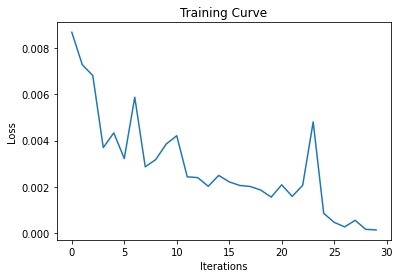

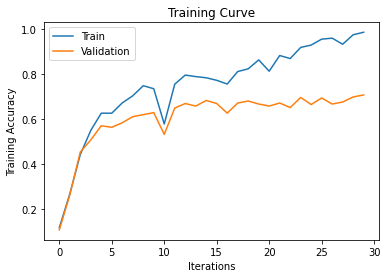

Final Training Accuracy: 0.9864763335837716
Final Validation Accuracy: 0.7072072072072072


In [ ]:
use_cuda = True
cnn_5 = CNN()
if use_cuda and torch.cuda.is_available():
  cnn_5.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
# Increase batch_size to 256, learning rate to 0.005
train(cnn_5,train_loader,val_loader,batch_size=256,learning_rate=0.005,num_epochs=30)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
# Best one: batch_size to 256, learning rate = 0.005, epoch = 30
# I use new CNN with 1 more fully connected layer and new kernel size of 2nd fully connected layer
# Final Training Accuracy: 0.986 Final Validation Accuracy: 0.707 
# This is the highest accuracy I got.



### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
print(f"Testing accuracy: {get_accuracy(cnn_5, test_loader)}")

Testing accuracy: 0.7184684684684685


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
# Data Loading from Google Drive
filePath = '/content/gdrive/My Drive/Colab Notebooks/aps360/Lab3/Lab3_Dataset/Lab3_Gestures'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# resize images and transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
# import data
data = torchvision.datasets.ImageFolder(filePath, transform=transform)  

In [ ]:
# Split into train, test, and validation
# 60% training  20% validation  20% testing samples
trainLength = int(round(0.6 * len(data)))
testLength = int(round(0.2 * len(data)))
valLength = int(round(0.2 * len(data)))
trainset, testset, validset = torch.utils.data.random_split(data,[trainLength,testLength,valLength])
    
# load data
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(validset, batch_size=32,num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32,num_workers=1, shuffle=True)

In [ ]:
save_features = [[],[],[]]
loader = [train_loader, val_loader, test_loader]
for i in range(len(loader)):
    for img, label in loader[i]:
        features = alexnet.features(img)
        save_features[i].append([torch.from_numpy(features.detach().numpy()),label])
print(features.shape)

torch.Size([28, 256, 6, 6])


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
# output = model(features)
# prob = F.softmax(output)

In [ ]:
# 2 convolutional layers with kernel size 3 and 2
# There are 256 input channels and 80 output channels in the 1st convolutional layer
# There are 80 input channels and 10 output channels in the 2nd convolutional layer
# activation function: ReLu 
# 2 fully-connected layers
# Totally 5 layers: 2 convolutional layers, 2 fully-connected layers, and 1 output layer
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        self.conv1 = nn.Conv2d(256, 80, kernel_size=3)
        self.conv2 = nn.Conv2d(80, 10, kernel_size=2)
        self.fc1 = nn.Linear(10*3*3, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 10*3*3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

CUDA is available!  Training on GPU ...
Epoch: 0, Train Accuracy: 0.24492862509391436
Epoch: 0, Val Accuracy: 0.19369369369369369
Epoch: 1, Train Accuracy: 0.585274229902329
Epoch: 1, Val Accuracy: 0.5472972972972973
Epoch: 2, Train Accuracy: 0.7235161532682194
Epoch: 2, Val Accuracy: 0.6824324324324325
Epoch: 3, Train Accuracy: 0.777610818933133
Epoch: 3, Val Accuracy: 0.7274774774774775
Epoch: 4, Train Accuracy: 0.8302028549962435
Epoch: 4, Val Accuracy: 0.7657657657657657
Epoch: 5, Train Accuracy: 0.8542449286250939
Epoch: 5, Val Accuracy: 0.7815315315315315
Epoch: 6, Train Accuracy: 0.8617580766341096
Epoch: 6, Val Accuracy: 0.7680180180180181
Epoch: 7, Train Accuracy: 0.9346356123215628
Epoch: 7, Val Accuracy: 0.8378378378378378
Epoch: 8, Train Accuracy: 0.9263711495116453
Epoch: 8, Val Accuracy: 0.8355855855855856
Epoch: 9, Train Accuracy: 0.9722013523666416
Epoch: 9, Val Accuracy: 0.9099099099099099
Epoch: 10, Train Accuracy: 0.9782118707738543
Epoch: 10, Val Accuracy: 0.9166666

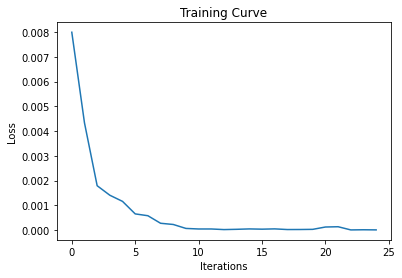

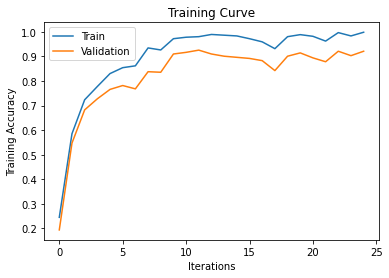

Final Training Accuracy: 0.9984973703981969
Final Validation Accuracy: 0.9211711711711712


In [ ]:
new_net = AlexNet()
use_cuda = True 
if use_cuda and torch.cuda.is_available():
  new_net.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(new_net,save_features[0], save_features[1], batch_size= 256, learning_rate = 0.005, num_epochs=25)  

In [ ]:
# The train and validation accuracy of AlexNet is higher than the best CNN model in part 3

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
print(f"Testing accuracy: {get_accuracy(new_net, save_features[2])}")
print("The test accuracy is higher than best CNN model in part 3(d) without transfer learning.")

Testing accuracy: 0.9279279279279279
The test accuracy is higher than best CNN model in part 3(d) without transfer learning.


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
# small data load
filePath = '/content/gdrive/My Drive/Colab Notebooks/aps360/Lab3/Lab3_Dataset/Lab3_small_Gestures'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# resize images and transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
# import data(3*9=27 images totally)
smalldata = torchvision.datasets.ImageFolder(filePath, transform=transform)  

In [ ]:
# Split into small train, test, and validation
# 21 training  3 validation  3 testing samples
small_trainset, small_testset, small_validset = torch.utils.data.random_split(smalldata,[21,3,3])
    
# load data
small_test_loader = torch.utils.data.DataLoader(small_testset, batch_size=32,num_workers=1, shuffle=True)

save_test_fatures = []
for img, label in small_test_loader:
  features = alexnet.features(img)
  save_test_fatures.append([torch.from_numpy(features.detach().numpy()),label])
accuracy = get_accuracy(new_net, save_test_fatures)
print("The final test accuract is {}%".format(accuracy*100))

The final test accuract is 100.0%


In [ ]:
# My model only have three images for each gesture. this is a very small dataset.
# Even though the accuracy seems higher, it can't show the real accuracy of model.
# Model trained by larger dataset and tested with larger dataset can show the accuray better.